# Workshop: Fraud and Signal Types

## Import Featurebyte Libraries
Featurebyte has an API and there is a Python SDK we can use to interface with the API

### Load the featurebyte library and connect to the local instance of featurebyte

In [1]:
# library imports
import pandas as pd
import numpy as np

# load the featurebyte SDK
import featurebyte as fb

# start the local server, then wait for it to be healthy before proceeding
fb.playground()

14:41:58 | INFO     | Using configuration file at: C:\Users\colin\.featurebyte\config.yaml
14:41:58 | INFO     | Active profile: local (http://127.0.0.1:8088)
14:42:00 | WARNING  | Service endpoint is inaccessible: http://127.0.0.1:8088
14:42:00 | INFO     | (1/4) Starting featurebyte services
14:43:11 | INFO     | (2/4) Creating local spark feature store
14:43:11 | INFO     | (3/4) Import datasets
14:43:25 | INFO     | Dataset grocery already exists, skipping import
14:43:25 | INFO     | Dataset healthcare already exists, skipping import
14:43:25 | INFO     | Dataset creditcard already exists, skipping import
14:43:25 | INFO     | (4/4) Playground environment started successfully. Ready to go! 🚀


In [2]:
# this script requires version 0.2.2 or higher
print("FeatureByte Version: " + fb.version)

FeatureByte Version: 0.3.1


### Load a new catalog

In [3]:
# get the functions to create a pre-built catalog
from ODSC_workshop_helper_functions import *

# create a new catalog for this tutorial
catalog = create_playground_credit_card_catalog()

14:43:52 | INFO     | Catalog activated: credit card playground 20230623:1443_34a854ec-3cd7-487d-8d19-83bbddd80e4f


Building a playground catalog for credit cards named [credit card playground 20230623:1443_34a854ec-3cd7-487d-8d19-83bbddd80e4f]
Creating new catalog
Catalog created
Registering the source tables
Registering the entities
Tagging the entities to columns in the data tables


## The Data Model
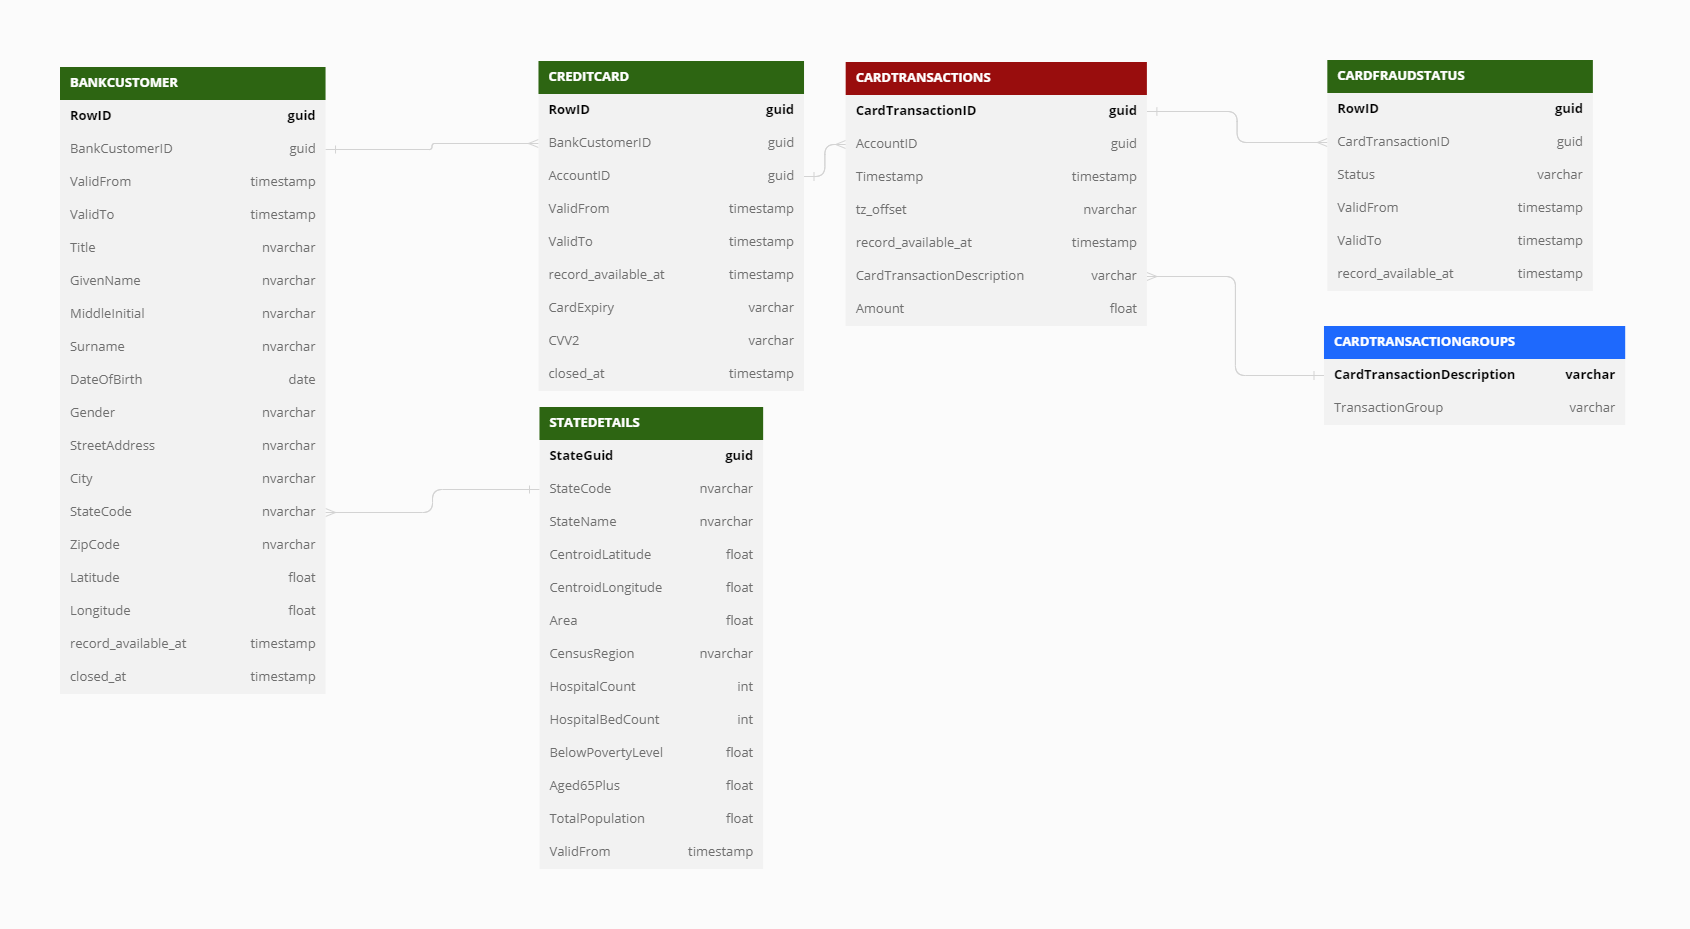

In [4]:
# get the table objects
card_transaction_groups_table = catalog.get_table("CARDTRANSACTIONGROUPS")
card_fraud_status_table = catalog.get_table("CARDFRAUDSTATUS")
card_transactions_table = catalog.get_table("CARDTRANSACTIONS")
credit_card_table = catalog.get_table("CREDITCARD")
state_details_table = catalog.get_table("STATEDETAILS")
bank_customer_table = catalog.get_table("BANKCUSTOMER")

# get the view objects
card_transaction_groups_view = card_transaction_groups_table.get_view()
card_fraud_status_view = card_fraud_status_table.get_view()
card_transactions_view = card_transactions_table.get_view()
credit_card_view = credit_card_table.get_view()
state_details_view = state_details_table.get_view()
bank_customer_view = bank_customer_table.get_view()

### List the Entities and Relationships

In [5]:
catalog.list_entities()

,id,name,serving_names,created_at
0,64953f3f098a1c31d309ca02,transaction_group,[TRANSACTIONGROUP],2023-06-23 06:44:15.780
1,64953f3f098a1c31d309ca01,gender,[GENDER],2023-06-23 06:44:15.666
2,64953f3f098a1c31d309ca00,card_transaction_description,[CARDTRANSACTIONDESCRIPTION],2023-06-23 06:44:15.551
3,64953f3f098a1c31d309c9ff,card_transaction,[CARDTRANSACTIONID],2023-06-23 06:44:15.435
4,64953f3f098a1c31d309c9fe,credit_card,[ACCOUNTID],2023-06-23 06:44:15.322
5,64953f3f098a1c31d309c9fd,USA_state,[STATECODE],2023-06-23 06:44:15.209
6,64953f3f098a1c31d309c9fc,bank_customer,[BANKCUSTOMERID],2023-06-23 06:44:15.081


In [6]:
catalog.list_relationships()

,id,relationship_type,entity,related_entity,relation_table,relation_table_type,enabled,created_at,updated_at
0,64953f41a98fecf1364246e3,child_parent,card_transaction_description,transaction_group,CARDTRANSACTIONGROUPS,dimension_table,True,2023-06-23 06:44:17.331,None
1,64953f40a98fecf1364246d1,child_parent,card_transaction,card_transaction_description,CARDTRANSACTIONS,event_table,True,2023-06-23 06:44:16.959,None
2,64953f40a98fecf1364246ca,child_parent,card_transaction,credit_card,CARDTRANSACTIONS,event_table,True,2023-06-23 06:44:16.835,None
3,64953f40a98fecf1364246be,child_parent,credit_card,bank_customer,CREDITCARD,scd_table,True,2023-06-23 06:44:16.594,None
4,64953f40a98fecf1364246ad,child_parent,bank_customer,gender,BANKCUSTOMER,scd_table,True,2023-06-23 06:44:16.137,None
5,64953f40a98fecf1364246a6,child_parent,bank_customer,USA_state,BANKCUSTOMER,scd_table,True,2023-06-23 06:44:16.019,None


### Enhance the Views via Joins and Filters

In [7]:
# join the customer ID to the transactions
card_transactions_view = card_transactions_view.join(
    credit_card_view[["AccountID", "BankCustomerID"]]
)

# join the customer state location to the transactions
card_transactions_view = card_transactions_view.join(
    bank_customer_view[["BankCustomerID", "StateCode"]]
)

# join the transaction groups to the transactions
card_transactions_view = card_transactions_view.join(
    card_transaction_groups_view
    )

card_transactions_view.sample(5)

,CardTransactionID,AccountID,Timestamp,tz_offset,CardTransactionDescription,Amount,BankCustomerID,StateCode,TransactionGroup
0,99d80dc3-072b-4868-8a26-ad2482179666,05cec76b-8ed5-4a53-b6cc-9f2de75fae28,2022-02-01 16:05:01,-07:00,internet purchase,420.00,48f770ae-f9d2-4c83-acf6-5fbe144380bb,CO,purchase
1,07ac7b2a-45b9-478b-a850-5ed3a9ce61e4,6855e803-46e0-451d-91ae-1fc010e94015,2022-05-03 17:30:21,-05:00,repayment,-32.50,35ddec0b-291d-4bec-a336-0172be4444bf,LA,purchase
2,539cc480-51f9-4887-b4e1-a22ea2f6c905,b0151d85-0af4-412e-a66e-a34ec6cfa527,2022-12-05 20:29:38,-06:00,fast food,42.85,85aa2564-882d-41f5-ad1c-62a8827a8c8e,IL,purchase
3,2763ab04-28b1-459c-b3e4-7c3dc30d43cf,72e77680-16fc-42f2-898f-895ce0e92115,2022-04-11 21:19:14,-04:00,internet purchase,1000.00,f3d12081-e63c-4129-960c-af3ee44c9d76,NY,purchase
4,f846df12-2403-4f62-88f2-c84829c5bdbf,1ce8cb34-c314-4ce5-838c-5461d25028f7,2022-05-24 16:47:25,-05:00,interest on cash advance,34.65,04d84913-7a7d-41c9-8b65-e3e4b316d55c,WI,cash advance


In [8]:
# filter the transactions view to only include purchases
purchases_view = card_transactions_view[card_transactions_view.TransactionGroup == "purchase"]

# filter the transactions view to only include interest payments
interest_payments_view = card_transactions_view[card_transactions_view.TransactionGroup == "interest"]

In [9]:
# join the customer ID to the fraud statuses and original transaction date
card_fraud_status_view = card_fraud_status_view.join(
    card_transactions_view[["AccountID", "BankCustomerID", "CardTransactionDescription"]]
)
card_fraud_status_view.sample(5)

,RowID,CardTransactionID,Status,ValidFrom,ValidTo,AccountID,Timestamp,tz_offset,CardTransactionDescription,BankCustomerID
0,076b6d68-998a-4429-bb6a-08b3d92d5d5a,e7bf69dd-8ef5-4d53-bbdd-bd8570ae6225,Reported,2022-11-17 07:22:56,2022-11-28 05:17:39,f5b2551b-7b68-4d9a-98c5-393831011f93,2022-11-08 21:27:32,-10:00,sport,d2549cea-b0ff-40a8-8dd0-4192bfd9f95c
1,925bdc03-84ec-4c8c-bf61-dde85f6abb53,417d54cd-b15a-41bb-a218-14209e754e33,Reported,2022-04-05 09:33:03,2022-06-28 06:12:16,5cfd27ae-bcc6-447a-8820-cdf0cf74f8aa,2022-03-23 17:05:46,-05:00,internet purchase,7d0d0468-6449-4767-b3f6-7797e474007a
2,dbab354c-0f9f-4e27-8408-3a6ac1530973,6a6ef713-0b6c-496f-b6f9-c7c171607205,Reported,2023-04-07 02:53:27,2023-04-12 17:00:10,491b3554-82a3-481a-bdd2-9310502e2802,2023-03-30 20:31:12,-05:00,gambling,b15989c5-380f-4e33-8ca9-df4c224ecf11
3,d7b4aeeb-e384-43de-b50a-6dc7e8715316,62895f83-242a-43a8-9ecd-a7670e4c828f,Reported,2022-07-04 22:24:35,2022-08-15 19:46:04,3434e500-d7e4-46ad-95cb-e4f6c033eade,2022-06-27 17:57:44,-04:00,alcohol,3cec552c-2685-47cf-8c71-8267ab509306
4,7831a448-5f66-4179-80c2-b404ef63fae2,6a6ef713-0b6c-496f-b6f9-c7c171607205,Fraud,2023-04-12 17:00:10,NaT,491b3554-82a3-481a-bdd2-9310502e2802,2023-03-30 20:31:12,-05:00,gambling,b15989c5-380f-4e33-8ca9-df4c224ecf11


In [10]:
# create an event view for the fraud reports
fraud_reports_view = card_fraud_status_table.get_change_view(
    "Status"
).join(card_transactions_view[["AccountID", "BankCustomerID", "CardTransactionDescription", "Amount"]])

# filter to only get the initial fraud report
fraud_reports_view = fraud_reports_view[fraud_reports_view.new_Status == 'Reported']

fraud_reports_view.sample(5)

,CardTransactionID,new_ValidFrom,past_ValidFrom,new_Status,past_Status,AccountID,Timestamp,tz_offset,CardTransactionDescription,Amount,BankCustomerID
0,417d54cd-b15a-41bb-a218-14209e754e33,2022-04-05 09:33:03,NaT,Reported,NaN,5cfd27ae-bcc6-447a-8820-cdf0cf74f8aa,2022-03-23 17:05:46,-05:00,internet purchase,30.00,7d0d0468-6449-4767-b3f6-7797e474007a
1,d71c9266-8c9a-4ca9-9372-f5d411e752f5,2022-01-10 10:25:47,NaT,Reported,NaN,db0b54cf-5f65-4881-ad77-6898f66b6366,2022-01-01 00:59:05,-07:00,internet purchase,1000.00,c0f57f26-68a3-4f3d-8043-79ea6f85d70c
2,a16bf59c-120f-46e2-928a-0612ae881a05,2023-05-12 08:41:19,NaT,Reported,NaN,71dad7ad-ff64-4b42-b9a0-c0e24c87b96a,2023-04-27 21:43:32,-07:00,internet purchase,89.65,74a58db3-86c1-4f0e-8005-cf281e28c20c
3,fafaddc5-3dbf-4a76-b430-5f598fdc4002,2023-02-24 10:22:37,NaT,Reported,NaN,5353bc22-8d72-46ca-a6c9-447570629fa8,2023-02-22 17:03:08,-06:00,alcohol,20.40,76b80d59-6ac4-4d54-a124-b7ed65568b88
4,9b92b852-d4b0-4cb5-876c-6a373be6423e,2022-10-07 10:54:22,NaT,Reported,NaN,03a3003b-4f78-424b-a265-1b3ae49c1240,2022-09-29 18:51:10,-04:00,books,75.47,0c6e619a-1932-4ded-8d43-c8c95051e4d5


## Observation Sets

In [11]:
# create an observation set for ten customers, paired with one of their transaction timestamps
sample_customer_observations = card_transactions_view[card_transactions_view.Timestamp.dt.year == 2022].create_observation_table(
    name="10 Random Credit Card Transactions during 2022",
    sample_rows=10,
    columns=["Timestamp", "BankCustomerID"],
    columns_rename_mapping={
        "Timestamp": "POINT_IN_TIME",
        "BankCustomerID": "BANKCUSTOMERID",
    }
).to_pandas()

# sort the observations by timestamp
sample_customer_observations = sample_customer_observations.sort_values(by="POINT_IN_TIME")

display(sample_customer_observations)

Done! |████████████████████████████████████████| 100% in 15.2s (0.07%/s)        


,POINT_IN_TIME,BANKCUSTOMERID
4,2022-02-10 17:37:49,561dddf4-77ac-49d8-916f-8d216851beae
9,2022-02-15 20:17:10,f87a1d95-cc8d-4a87-9ceb-6f81da2957af
2,2022-03-01 16:13:10,38e24a43-6e70-432c-b8f4-9049dae8e4e5
6,2022-03-07 22:17:24,bbf2cbe6-e254-4cff-8d8d-6034ad612f22
3,2022-04-11 16:14:26,38e24a43-6e70-432c-b8f4-9049dae8e4e5
8,2022-10-17 20:34:17,d3f17f17-608f-464f-b17f-cca18915a201
7,2022-10-31 18:01:33,adf8b180-d757-413d-a3f7-5bcc910c3aee
0,2022-11-01 17:36:36,04fef124-b926-4a9b-810f-d9c63db91fcf
5,2022-11-08 20:56:43,8f98ba9a-2a7c-4d4c-b31f-ed731ccbc3a8
1,2022-11-25 22:34:12,0c6e619a-1932-4ded-8d43-c8c95051e4d5


In [12]:
# create a view for the fraud reports, and declare a new timestamp column, 24 hours after the original timestamp
temp_view = card_fraud_status_view[card_fraud_status_view.Timestamp.dt.year == 2022]
temp_view["Temp"] = temp_view.ValidFrom + pd.Timedelta(days=1)

# create the observation set
sample_customer_observations_with_fraud = temp_view.create_observation_table(
    name="10 Randomly Selected Fraudulent Transactions during 2022",
    sample_rows=10,
    columns=["Temp", "BankCustomerID"],
    columns_rename_mapping={
        "Temp": "POINT_IN_TIME",
        "BankCustomerID": "BANKCUSTOMERID",
    }
).to_pandas()

# sort the observations by timestamp
sample_customer_observations_with_fraud = sample_customer_observations_with_fraud.sort_values(by="POINT_IN_TIME")

display(sample_customer_observations_with_fraud)

Done! |████████████████████████████████████████| 100% in 12.1s (0.08%/s)        


,POINT_IN_TIME,BANKCUSTOMERID
5,2022-07-07 21:25:54,0ed7b5ee-0ca8-4d47-9caa-e484e9e5dc3e
2,2022-08-16 19:46:04,3cec552c-2685-47cf-8c71-8267ab509306
9,2022-09-16 08:37:18,a32d8d43-04de-46f3-a99a-7d3e025f7f76
7,2022-09-20 16:33:45,478b1cc8-790d-4ef1-8b43-52cc6fd52e14
8,2022-10-06 15:02:29,a32d8d43-04de-46f3-a99a-7d3e025f7f76
6,2022-10-06 18:34:16,478b1cc8-790d-4ef1-8b43-52cc6fd52e14
1,2022-10-08 10:54:22,0c6e619a-1932-4ded-8d43-c8c95051e4d5
4,2022-11-22 12:26:58,a5404c5c-9355-4540-8fac-78bed7abce72
0,2022-12-08 17:46:05,0c6e619a-1932-4ded-8d43-c8c95051e4d5
3,2022-12-29 20:30:00,a5404c5c-9355-4540-8fac-78bed7abce72


In [13]:
# create an observation set for ten transactions
sample_transaction_observations = card_transactions_view[card_transactions_view.Timestamp.dt.year == 2022].create_observation_table(
    name="10 Random Credit Card Transaction IDs during 2022",
    sample_rows=10,
    columns=["Timestamp", "CardTransactionID"],
    columns_rename_mapping={
        "Timestamp": "POINT_IN_TIME",
        "CardTransactionID": "CARDTRANSACTIONID",
    }
).to_pandas()

# sort the observations by timestamp
sample_transaction_observations = sample_transaction_observations.sort_values(by="POINT_IN_TIME")

display(sample_transaction_observations)

Done! |████████████████████████████████████████| 100% in 12.2s (0.08%/s)        


,POINT_IN_TIME,CARDTRANSACTIONID
9,2022-01-12 16:42:29,143824b0-157d-4945-b69d-687d0115bd9b
5,2022-01-31 18:19:42,f7e2bff6-dbfb-4bad-843f-9b303050f68f
3,2022-02-28 16:30:42,66b3801a-6d5d-4c0c-aba9-863485bbc11e
0,2022-03-31 17:43:12,0e200094-7b69-45dc-a90c-655ad1fa3517
7,2022-07-05 16:05:17,e70fe473-de87-4ec7-9f35-d7aff2ef13b8
8,2022-07-07 15:42:17,116441a5-cbd9-40f4-99ce-99cea52c13ba
4,2022-07-12 20:01:12,2fb01fc0-fe52-4632-9183-fe7806e5ab4f
6,2022-08-19 19:18:53,032f82ab-2cf2-4beb-93f1-fd57e4915aa3
2,2022-10-24 17:34:38,0f3c0809-a36c-4706-87ed-d57f971c50a4
1,2022-11-18 20:23:17,dd030def-92a4-4b31-8344-f242419d00af


In [14]:
# create a view for the fraud reports, and declare a new timestamp column, 24 hours after the original timestamp
temp_view = card_fraud_status_view[card_fraud_status_view.Timestamp.dt.year == 2022]
temp_view["Temp_Timestamp"] = temp_view.ValidFrom + pd.Timedelta(days=1)

# create the observation set
sample_transaction_observations_with_fraud = temp_view.create_observation_table(
    name="10 Randomly Selected Fraudulent Transactions IDs during 2022",
    sample_rows=10,
    columns=["Temp_Timestamp", "CardTransactionID"],
    columns_rename_mapping={
        "Temp_Timestamp": "POINT_IN_TIME",
        "CardTransactionID": "CARDTRANSACTIONID",
    }
).to_pandas()

# sort the observations by timestamp
sample_transaction_observations_with_fraud = sample_transaction_observations_with_fraud.sort_values(by="POINT_IN_TIME")

display(sample_transaction_observations_with_fraud)

Done! |████████████████████████████████████████| 100% in 12.1s (0.08%/s)        


,POINT_IN_TIME,CARDTRANSACTIONID
2,2022-07-05 22:24:35,62895f83-242a-43a8-9ecd-a7670e4c828f
5,2022-07-07 21:25:54,bb4939e5-03b3-46d7-938a-13fb0416521b
9,2022-07-08 22:46:29,1bdde7fd-8840-4a63-b0a2-000930e020e5
4,2022-07-14 13:26:46,bb4939e5-03b3-46d7-938a-13fb0416521b
7,2022-09-20 16:33:45,9451dd1f-bcc7-4eab-9c28-3245e3b6cf99
8,2022-10-06 15:02:29,4336ec8b-89bf-457f-8652-827023a48faa
6,2022-10-06 18:34:16,9451dd1f-bcc7-4eab-9c28-3245e3b6cf99
1,2022-10-08 10:54:22,9b92b852-d4b0-4cb5-876c-6a373be6423e
3,2022-11-22 12:26:58,2b1cf944-aec5-471a-bda2-f4f024584971
0,2022-12-08 17:46:05,9b92b852-d4b0-4cb5-876c-6a373be6423e


## Feature Engineering: Signal Types that May Help Predict Fraud

### Signal Type: Recency

A recency feature captures an attribute of the latest event to occur, e.g., the last product purchased, or elapsed time since the last purchase.

#### Create events from an SCD

In [15]:
# create a change view on the fraud status, that captures fraud status changes
card_fraud_status_change_view = card_fraud_status_table.get_change_view(
    track_changes_column="Status",
)

# filter for only confirmed fraud
card_fraud_status_change_view_confirmed = card_fraud_status_change_view[card_fraud_status_change_view.new_Status == "Reported"].copy()

# join the transactions view to get the transaction details
card_fraud_status_change_view_confirmed = card_fraud_status_change_view_confirmed.join(
    card_transactions_view[["CardTransactionID", "Timestamp", "tz_offset", "AccountID", "BankCustomerID", "CardTransactionDescription", "Amount"]],
)

card_fraud_status_change_view_confirmed.sample()

,CardTransactionID,new_ValidFrom,past_ValidFrom,new_Status,past_Status,AccountID,Timestamp,tz_offset,CardTransactionDescription,Amount,BankCustomerID
0,417d54cd-b15a-41bb-a218-14209e754e33,2022-04-05 09:33:03,NaT,Reported,NaN,5cfd27ae-bcc6-447a-8820-cdf0cf74f8aa,2022-03-23 17:05:46,-05:00,internet purchase,30.00,7d0d0468-6449-4767-b3f6-7797e474007a
1,d71c9266-8c9a-4ca9-9372-f5d411e752f5,2022-01-10 10:25:47,NaT,Reported,NaN,db0b54cf-5f65-4881-ad77-6898f66b6366,2022-01-01 00:59:05,-07:00,internet purchase,1000.00,c0f57f26-68a3-4f3d-8043-79ea6f85d70c
2,a16bf59c-120f-46e2-928a-0612ae881a05,2023-05-12 08:41:19,NaT,Reported,NaN,71dad7ad-ff64-4b42-b9a0-c0e24c87b96a,2023-04-27 21:43:32,-07:00,internet purchase,89.65,74a58db3-86c1-4f0e-8005-cf281e28c20c
3,fafaddc5-3dbf-4a76-b430-5f598fdc4002,2023-02-24 10:22:37,NaT,Reported,NaN,5353bc22-8d72-46ca-a6c9-447570629fa8,2023-02-22 17:03:08,-06:00,alcohol,20.40,76b80d59-6ac4-4d54-a124-b7ed65568b88
4,9b92b852-d4b0-4cb5-876c-6a373be6423e,2022-10-07 10:54:22,NaT,Reported,NaN,03a3003b-4f78-424b-a265-1b3ae49c1240,2022-09-29 18:51:10,-04:00,books,75.47,0c6e619a-1932-4ded-8d43-c8c95051e4d5
5,9451dd1f-bcc7-4eab-9c28-3245e3b6cf99,2022-09-19 16:33:45,NaT,Reported,NaN,71eae2aa-2060-44fc-b3e6-86f9c86d301a,2022-09-13 21:47:11,-04:00,alcohol,41.70,478b1cc8-790d-4ef1-8b43-52cc6fd52e14
6,e7bf69dd-8ef5-4d53-bbdd-bd8570ae6225,2022-11-17 07:22:56,NaT,Reported,NaN,f5b2551b-7b68-4d9a-98c5-393831011f93,2022-11-08 21:27:32,-10:00,sport,57.95,d2549cea-b0ff-40a8-8dd0-4192bfd9f95c
7,4336ec8b-89bf-457f-8652-827023a48faa,2022-09-15 08:37:18,NaT,Reported,NaN,da1ad1ea-0f0f-4e67-8041-8f898714f851,2022-09-01 20:42:10,-04:00,internet purchase,50.00,a32d8d43-04de-46f3-a99a-7d3e025f7f76
8,62895f83-242a-43a8-9ecd-a7670e4c828f,2022-07-04 22:24:35,NaT,Reported,NaN,3434e500-d7e4-46ad-95cb-e4f6c033eade,2022-06-27 17:57:44,-04:00,alcohol,44.99,3cec552c-2685-47cf-8c71-8267ab509306
9,7c9c0be8-8df3-4b44-b22b-375c4626ab4b,2023-06-03 16:08:15,NaT,Reported,NaN,901ea2dd-7386-45a4-b11e-1e2588a3c76b,2023-05-26 14:16:51,-04:00,sport,39.00,a441c83b-ffb0-4d49-9a4a-2361eead4cb5


#### How much time has elapsed since the customer's last fraudulent transaction report?

In [16]:
# get the latest date for each customer
customer_latest_fraud = card_fraud_status_change_view_confirmed.groupby(
    "BankCustomerID"
).aggregate_over(
    "Timestamp",
    method=fb.AggFunc.LATEST,
    feature_names=["Customer Latest Fraud Date"],
    windows=['365d']
)

# get the time since that date
days_since_customer_latest_fraud = (RequestColumn.point_in_time() - customer_latest_fraud["Customer Latest Fraud Date"]).dt.day
days_since_customer_latest_fraud.name = "Days Since Customer Latest Fraud"
customer_latest_fraud["Days Since Customer Latest Fraud"] = days_since_customer_latest_fraud

#### What was the most recent fraudulent transaction description across all customers?

In [17]:
latest_fraudulent_transaction_description = card_fraud_status_change_view_confirmed.groupby(
    []
).aggregate_over(
    "CardTransactionDescription",
    method=fb.AggFunc.LATEST,
    feature_names=["Latest Fraud Description"],
    windows=['365d']
)

#### Materialize a sample of the recency features

In [18]:
recency_features = fb.FeatureGroup([
    days_since_customer_latest_fraud,
    latest_fraudulent_transaction_description
])

# display sample values
recency_features.preview(
    sample_customer_observations_with_fraud
)

,POINT_IN_TIME,BANKCUSTOMERID,Days Since Customer Latest Fraud,Latest Fraud Description
5,2022-07-07 21:25:54,0ed7b5ee-0ca8-4d47-9caa-e484e9e5dc3e,24.186100,internet purchase
2,2022-08-16 19:46:04,3cec552c-2685-47cf-8c71-8267ab509306,50.075231,internet purchase
9,2022-09-16 08:37:18,a32d8d43-04de-46f3-a99a-7d3e025f7f76,14.496620,internet purchase
7,2022-09-20 16:33:45,478b1cc8-790d-4ef1-8b43-52cc6fd52e14,6.782338,alcohol
8,2022-10-06 15:02:29,a32d8d43-04de-46f3-a99a-7d3e025f7f76,34.764109,alcohol
6,2022-10-06 18:34:16,478b1cc8-790d-4ef1-8b43-52cc6fd52e14,22.866030,alcohol
1,2022-10-08 10:54:22,0c6e619a-1932-4ded-8d43-c8c95051e4d5,8.668889,books
4,2022-11-22 12:26:58,a5404c5c-9355-4540-8fac-78bed7abce72,7.870451,airfare
0,2022-12-08 17:46:05,0c6e619a-1932-4ded-8d43-c8c95051e4d5,69.954803,airfare
3,2022-12-29 20:30:00,a5404c5c-9355-4540-8fac-78bed7abce72,45.205891,airfare


### Signal Type: Cross-Aggregation

Cross-aggregation features involve grouping the data by a specific entity and aggregating a column's values across categories of a categorical column. Each feature value is represented as a dictionary with category names as keys and the corresponding aggregated values as values. For example, a shopping basket of items (a count or value of items purchased) is a cross-aggregation feature.

#### On what transaction description has the customer spent the most over the past 28 days?

In [19]:
# create a cross aggregation of the transaction amount by customer and description over the past 28 days
customer_transaction_descriptions = card_transactions_view.groupby(
    "BankCustomerID",
    category="CardTransactionDescription"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.SUM,
    feature_names=["Total Amount by Customer and Description"],
    windows=['28d']
)["Total Amount by Customer and Description"]

# create a feature that is the highest category
customer_highest_spend_category = customer_transaction_descriptions.cd.most_frequent()
customer_highest_spend_category.name = "Customer Highest Spend Category"

#### What was the most common transaction description for fraudulent transactions over the past 60 days?

In [20]:
# create a cross aggregation of the transaction amount by description for fraudulent transactions over the past 60 days
fraudulent_transaction_description = card_fraud_status_change_view_confirmed.groupby(
    [],
    category="CardTransactionDescription"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["Fraud Total Amount by Description"],
    windows=['60d']
)["Fraud Total Amount by Description"]

# create a feature that is the highest category
fraudulent_most_frequent_category = fraudulent_transaction_description.cd.most_frequent()
fraudulent_most_frequent_category.fillna("-")
fraudulent_most_frequent_category.name = "Fraudulent Most Frequent Category"

#### Materialize a sample of the cross-aggregation features

In [21]:
cross_aggregation_features = fb.FeatureGroup([
    customer_highest_spend_category,
    fraudulent_most_frequent_category
])

# display sample values
cross_aggregation_features.preview(
    sample_customer_observations_with_fraud
)

,POINT_IN_TIME,BANKCUSTOMERID,Customer Highest Spend Category,Fraudulent Most Frequent Category
5,2022-07-07 21:25:54,0ed7b5ee-0ca8-4d47-9caa-e484e9e5dc3e,internet purchase,alcohol
2,2022-08-16 19:46:04,3cec552c-2685-47cf-8c71-8267ab509306,supermarket,internet purchase
9,2022-09-16 08:37:18,a32d8d43-04de-46f3-a99a-7d3e025f7f76,internet purchase,internet purchase
7,2022-09-20 16:33:45,478b1cc8-790d-4ef1-8b43-52cc6fd52e14,internet purchase,alcohol
8,2022-10-06 15:02:29,a32d8d43-04de-46f3-a99a-7d3e025f7f76,internet purchase,alcohol
6,2022-10-06 18:34:16,478b1cc8-790d-4ef1-8b43-52cc6fd52e14,internet purchase,alcohol
1,2022-10-08 10:54:22,0c6e619a-1932-4ded-8d43-c8c95051e4d5,internet purchase,alcohol
4,2022-11-22 12:26:58,a5404c5c-9355-4540-8fac-78bed7abce72,internet purchase,airfare
0,2022-12-08 17:46:05,0c6e619a-1932-4ded-8d43-c8c95051e4d5,internet transfer,airfare
3,2022-12-29 20:30:00,a5404c5c-9355-4540-8fac-78bed7abce72,internet purchase,airfare


### Signal Type: Similarity

Similarity features compare an individual entity’s attributes or past activity to a group, e.g., a ratio of a person’s income to the average income of people with the same role, or a comparison of a person’s purchases to those of all people living in the same geographic region. In addition, similarity features can compare the aggregation statistics or activities of a group that is related to the entity being analyzed with those of a different group.

#### Is the transaction description a match to recent fraudulent transactions from all customers?

In [22]:
# get a count of transaction descriptions from recent fraudulent transactions
recent_fraudulent_transaction_description_counts = card_fraud_status_change_view_confirmed.groupby(
    [],
    category="CardTransactionDescription"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["Recent Fraudulent Transaction Descriptions 14d"],
    windows=['14d']
)["Recent Fraudulent Transaction Descriptions 14d"]

# create a featur that is the transaction description
transaction_description = card_transactions_view.CardTransactionDescription.as_feature("Transaction Description")

# create a feature that flags whether the single transaction has a description that matches any recent fraudulent transaction descriptions
matches_recent_fraudulent_transaction_description = recent_fraudulent_transaction_description_counts.cd.get_relative_frequency(transaction_description)
matches_recent_fraudulent_transaction_description.fillna(0)
matches_recent_fraudulent_transaction_description.name = "Matches Recent Fraudulent Transaction Description"

#### Is the transaction description an exact match to the latest fraudulent transaction across all customers?

In [23]:
# whether a transaction description matches the latest fraudulent transaction description
matches_latest_fraudulent_transaction_description = card_transactions_view.CardTransactionDescription.as_feature("Matches Latest Fraudulent Transaction Description")
matches_latest_fraudulent_transaction_description[matches_latest_fraudulent_transaction_description == transaction_description] = "Yes"
matches_latest_fraudulent_transaction_description[matches_latest_fraudulent_transaction_description != transaction_description] = "No"

#### Is the transaction amount similar to recent fraudulant transactions?

In [24]:
# create a feature that is the Z-score of the transaction amount versus recent fraudulent transactions

x = card_transactions_view.Amount.as_feature("Transaction Amount")

mu = card_fraud_status_change_view_confirmed.groupby(
    []
).aggregate_over(
    "Amount",
    method=fb.AggFunc.AVG,
    feature_names=["Mean Fraudulent Transaction Amount 28d"],
    windows=['28d']
)["Mean Fraudulent Transaction Amount 28d"]

sigma = card_fraud_status_change_view_confirmed.groupby(
    []
).aggregate_over(
    "Amount",
    method=fb.AggFunc.STD,
    feature_names=["Std Fraudulent Transaction Amount 28d"],
    windows=['28d']
)["Std Fraudulent Transaction Amount 28d"]

z_score_vs_fraud_28d = (x - mu) / sigma
z_score_vs_fraud_28d.fillna(0)
z_score_vs_fraud_28d.name = "Z-Score of Transaction Amount vs Recent Fraudulent Transactions 28d"

# display sample values
z_score_vs_fraud_28d.preview(
    sample_transaction_observations_with_fraud
)

,POINT_IN_TIME,CARDTRANSACTIONID,Z-Score of Transaction Amount vs Recent Fraudulent Transactions 28d
2,2022-07-05 22:24:35,62895f83-242a-43a8-9ecd-a7670e4c828f,0.000000
5,2022-07-07 21:25:54,bb4939e5-03b3-46d7-938a-13fb0416521b,1.000000
9,2022-07-08 22:46:29,1bdde7fd-8840-4a63-b0a2-000930e020e5,-0.793287
4,2022-07-14 13:26:46,bb4939e5-03b3-46d7-938a-13fb0416521b,1.410558
7,2022-09-20 16:33:45,9451dd1f-bcc7-4eab-9c28-3245e3b6cf99,-1.000000
8,2022-10-06 15:02:29,4336ec8b-89bf-457f-8652-827023a48faa,1.000000
6,2022-10-06 18:34:16,9451dd1f-bcc7-4eab-9c28-3245e3b6cf99,-1.000000
1,2022-10-08 10:54:22,9b92b852-d4b0-4cb5-876c-6a373be6423e,1.374325
3,2022-11-22 12:26:58,2b1cf944-aec5-471a-bda2-f4f024584971,1.000000
0,2022-12-08 17:46:05,9b92b852-d4b0-4cb5-876c-6a373be6423e,-0.835601


#### Create a feature that compares a customer's recent transaction descriptions to those of customers who live in the same geographic region

In [25]:
# get the customer's transaction descriptions for the past 28 days
customer_transaction_descriptions_28d = card_transactions_view.groupby(
    "BankCustomerID",
    category="CardTransactionDescription"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["Customer Transaction Descriptions 28d"],
    windows=['28d']
)["Customer Transaction Descriptions 28d"]

# get the state total's transaction descriptions for the past 28 days
state_transaction_descriptions_28d = card_transactions_view.groupby(
    "StateCode",
    category="CardTransactionDescription"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["State Transaction Descriptions 28d"],
    windows=['28d']
)["State Transaction Descriptions 28d"]

# get the cosine similarity between the customer's transaction descriptions and the state's transaction descriptions
customer_state_similarity_28d = customer_transaction_descriptions_28d.cd.cosine_similarity(state_transaction_descriptions_28d)
customer_state_similarity_28d.fillna(0)
customer_state_similarity_28d.name = "Customer State Similarity 28d"

#### Materialize a sample of the similarity features

In [26]:
similarity_features = fb.FeatureGroup([
    matches_recent_fraudulent_transaction_description,
    matches_latest_fraudulent_transaction_description,
    z_score_vs_fraud_28d,
    customer_state_similarity_28d
])

# display sample values
similarity_features.preview(
    sample_transaction_observations
)

,POINT_IN_TIME,CARDTRANSACTIONID,Matches Recent Fraudulent Transaction Description,Matches Latest Fraudulent Transaction Description,Z-Score of Transaction Amount vs Recent Fraudulent Transactions 28d,Customer State Similarity 28d
9,2022-01-12 16:42:29,143824b0-157d-4945-b69d-687d0115bd9b,0.0,No,0.000000,0.398137
5,2022-01-31 18:19:42,f7e2bff6-dbfb-4bad-843f-9b303050f68f,0.0,No,0.000000,0.858665
3,2022-02-28 16:30:42,66b3801a-6d5d-4c0c-aba9-863485bbc11e,0.0,No,0.000000,0.114209
0,2022-03-31 17:43:12,0e200094-7b69-45dc-a90c-655ad1fa3517,0.0,No,0.000000,0.812570
7,2022-07-05 16:05:17,e70fe473-de87-4ec7-9f35-d7aff2ef13b8,0.0,No,0.000000,0.933809
8,2022-07-07 15:42:17,116441a5-cbd9-40f4-99ce-99cea52c13ba,0.5,No,1.652486,0.650501
4,2022-07-12 20:01:12,2fb01fc0-fe52-4632-9183-fe7806e5ab4f,0.0,No,-0.971518,0.965172
6,2022-08-19 19:18:53,032f82ab-2cf2-4beb-93f1-fd57e4915aa3,0.0,No,0.000000,0.851960
2,2022-10-24 17:34:38,0f3c0809-a36c-4706-87ed-d57f971c50a4,0.0,No,0.000000,0.000000
1,2022-11-18 20:23:17,dd030def-92a4-4b31-8344-f242419d00af,0.0,No,0.000000,0.902966


### Signal Type: Stability

Stability features compare recent data values and events to those of earlier periods, e.g. the similarity of a customer’s most recent shopping bask items versus those of the previous 6 months.

#### Is the transaction amount similar to the customer's past transactions?

In [27]:
x = card_transactions_view.Amount.as_feature("Transaction Amount")

mu = card_transactions_view.groupby(
    "BankCustomerID"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.AVG,
    feature_names=["customer mean transaction amount 365d"],
    windows=['365d']
)["customer mean transaction amount 365d"]

sigma = card_transactions_view.groupby(
    "BankCustomerID"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.STD,
    feature_names=["customer stdev transaction amount 365d"],
    windows=['365d']
)["customer stdev transaction amount 365d"]

transaction_z_score = (x - mu) / sigma
transaction_z_score.name = "Transaction Z Score 365d"

#### Are the customer's recent transaction descriptions similar to their earlier transactions?

In [28]:
# get transactions from the past week and the past year
customer_transaction_descriptions_1w1yr = card_transactions_view.groupby(
    "BankCustomerID",
    category="CardTransactionDescription"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["customer transaction desc 1w", "customer transaction desc 1yr"],
    windows=['7d', '365d']
)

# create a feature from the cosine similarity between the two windows
transaction_count_cosine_similarity = customer_transaction_descriptions_1w1yr["customer transaction desc 1w"].cd.cosine_similarity(
    customer_transaction_descriptions_1w1yr["customer transaction desc 1yr"]
)
transaction_count_cosine_similarity.name = "Customer Transaction Desc Stability 1w1yr"

#### Materialize a sample of the stability features

In [29]:
stability_features = fb.FeatureGroup([
    transaction_z_score,
    transaction_count_cosine_similarity
])

# display sample values
stability_features.preview(
    sample_transaction_observations
)

,POINT_IN_TIME,CARDTRANSACTIONID,Transaction Z Score 365d,Customer Transaction Desc Stability 1w1yr
9,2022-01-12 16:42:29,143824b0-157d-4945-b69d-687d0115bd9b,0.799672,0.925820
5,2022-01-31 18:19:42,f7e2bff6-dbfb-4bad-843f-9b303050f68f,-0.400439,0.527589
3,2022-02-28 16:30:42,66b3801a-6d5d-4c0c-aba9-863485bbc11e,-0.685599,NaN
0,2022-03-31 17:43:12,0e200094-7b69-45dc-a90c-655ad1fa3517,-0.045193,0.366676
7,2022-07-05 16:05:17,e70fe473-de87-4ec7-9f35-d7aff2ef13b8,-0.139922,0.631052
8,2022-07-07 15:42:17,116441a5-cbd9-40f4-99ce-99cea52c13ba,-0.049956,0.469101
4,2022-07-12 20:01:12,2fb01fc0-fe52-4632-9183-fe7806e5ab4f,-0.139475,0.920890
6,2022-08-19 19:18:53,032f82ab-2cf2-4beb-93f1-fd57e4915aa3,-0.144364,0.710204
2,2022-10-24 17:34:38,0f3c0809-a36c-4706-87ed-d57f971c50a4,0.316658,0.282682
1,2022-11-18 20:23:17,dd030def-92a4-4b31-8344-f242419d00af,0.009872,0.655919


### Signal Type: Clumpiness

Clumpiness features measure the occurrence of long gaps in time between bursts of multiple events. For example, binge-watching Netflix TV series is a clumpy behavior, while washing a car every Saturday is not.

#### Calculate the Inter-Event-Times

In [30]:
# get the inter-event-times for the customer's transactions
view = purchases_view.copy()
ts_col = view[view.timestamp_column]
view["InterEventTime"] = (ts_col - ts_col.lag("BankCustomerID")).dt.day
view.preview()

,CardTransactionID,AccountID,Timestamp,tz_offset,CardTransactionDescription,Amount,BankCustomerID,StateCode,TransactionGroup,InterEventTime
0,0abd722e-57fb-4bf5-bb00-1dfc365436ce,9a267753-dc84-421e-9c8a-d4b273b3bfab,2022-01-04 15:56:47,-05:00,internet purchase,100.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,NaN
1,7300eaa4-5550-4f33-aa10-1c906d3cfcb5,9a267753-dc84-421e-9c8a-d4b273b3bfab,2022-01-04 17:40:53,-05:00,internet purchase,100.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,0.072292
2,32521977-924d-4155-be50-8e7bfb3ffc10,5d20f994-1e5d-4839-b266-fe7060b2909f,2022-01-06 14:17:38,-05:00,internet purchase,130.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,1.858854
3,ee79a310-9f27-44f2-a198-8d33fea12211,5d20f994-1e5d-4839-b266-fe7060b2909f,2022-01-06 16:47:33,-05:00,internet purchase,130.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,0.104109
4,3c871041-5217-4e1e-9286-996dc4cd150b,5d20f994-1e5d-4839-b266-fe7060b2909f,2022-01-06 17:31:14,-05:00,internet purchase,130.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,0.030336
5,eb6a4a83-7adf-4fac-8148-5988153ad167,5d20f994-1e5d-4839-b266-fe7060b2909f,2022-01-06 18:39:06,-05:00,internet purchase,130.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,0.047130
6,faae4867-a06d-408e-a72a-cfb41e675829,5d20f994-1e5d-4839-b266-fe7060b2909f,2022-01-06 19:25:15,-05:00,internet purchase,130.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,0.032049
7,d83c592e-b8e0-4f90-ac50-8f5c05d062c3,5d20f994-1e5d-4839-b266-fe7060b2909f,2022-01-06 19:31:13,-05:00,internet purchase,130.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,0.004144
8,c916d723-5a38-42aa-a7e2-afb1bb774dff,5d20f994-1e5d-4839-b266-fe7060b2909f,2022-01-06 19:33:45,-05:00,internet purchase,132.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,0.001759
9,3e8596c8-2021-487d-a34e-b82a7a3d43cb,5d20f994-1e5d-4839-b266-fe7060b2909f,2022-01-06 20:34:26,-05:00,internet purchase,139.0,044baedf-0e20-4c5d-ac40-a8ed8e276330,FL,purchase,0.042141


#### Does the customer exhibit binge shopping behaviours or erratic timing of purchases?

In [31]:
# calculate the entropy and coefficient of variation of the inter-event-times
windows = ["28d"]

# we can easily create inter-event times
view = card_transactions_view.copy()
ts_col = view[view.timestamp_column]
view["IET"] = (ts_col - ts_col.lag("BankCustomerID")).dt.day

# from the inter-event times we can transform and aggregate to get IET clumpiness and diversity metrics
a = view["IET"]
a[a < 0.001] = 0.001
view["a * log(a)"] = a * a.log()

clumpiness_features = fb.FeatureGroup([])
for window in windows:
    b = view.groupby("BankCustomerID").aggregate_over(
        "IET", 
        method=fb.AggFunc.SUM,
        windows=[window],
        feature_names=[f"sum(a){window}"],
    )[f"sum(a){window}"]
    # handle zeroes
    b = b.astype(float)
    b[b < 1e-8] = 1e-8

    mu = view.groupby("BankCustomerID").aggregate_over(
        "IET", 
        method=fb.AggFunc.AVG,
        windows=[window],
        feature_names=[f"sum(a){window}"],
    )[f"sum(a){window}"]
    # handle zeroes
    mu = mu.astype(float)
    mu[mu < 1e-8] = 1e-8

    # clumpiness - entropy
    entropy = view.groupby("BankCustomerID").aggregate_over(
        "a * log(a)", 
        method=fb.AggFunc.SUM,
        windows=[window],
        feature_names=[f"sum(a * log(a)){window}"],
        )[f"sum(a * log(a)){window}"] * -1 / b + mu.log()
    entropy.fillna(0)
    clumpiness_features[f"Card Transactions Timing Clumpiness Entropy (zero corrected)_({window})"] = entropy

    # regularity - coefficient of variation
    cv = view.groupby("BankCustomerID").aggregate_over(
        "IET",
        method=fb.AggFunc.STD,
        windows=[window],
        feature_names=[f"std(a){window}"],
    )[f"std(a){window}"] / mu
    cv.fillna(0)
    clumpiness_features[f"Card Transactions Timing Coefficient of Variation (zero corrected)_({window})"] = cv

#### Materialize a sample of the clumpiness features

In [32]:
# display sample values
clumpiness_features.preview(
    sample_customer_observations
)

,POINT_IN_TIME,BANKCUSTOMERID,Card Transactions Timing Clumpiness Entropy (zero corrected)_(28d),Card Transactions Timing Coefficient of Variation (zero corrected)_(28d)
4,2022-02-10 17:37:49,561dddf4-77ac-49d8-916f-8d216851beae,-0.644621,1.101575
9,2022-02-15 20:17:10,f87a1d95-cc8d-4a87-9ceb-6f81da2957af,-1.225048,1.952797
2,2022-03-01 16:13:10,38e24a43-6e70-432c-b8f4-9049dae8e4e5,-1.300773,2.215229
6,2022-03-07 22:17:24,bbf2cbe6-e254-4cff-8d8d-6034ad612f22,-1.254404,2.177767
3,2022-04-11 16:14:26,38e24a43-6e70-432c-b8f4-9049dae8e4e5,-1.419800,2.352135
8,2022-10-17 20:34:17,d3f17f17-608f-464f-b17f-cca18915a201,-0.880418,1.568222
7,2022-10-31 18:01:33,adf8b180-d757-413d-a3f7-5bcc910c3aee,-1.679795,2.974492
0,2022-11-01 17:36:36,04fef124-b926-4a9b-810f-d9c63db91fcf,-1.138502,1.812449
5,2022-11-08 20:56:43,8f98ba9a-2a7c-4d4c-b31f-ed731ccbc3a8,-1.632785,2.701615
1,2022-11-25 22:34:12,0c6e619a-1932-4ded-8d43-c8c95051e4d5,-1.241072,1.863133


### Signal Type: Diversity

Diversity features measure the variability of data values, e.g., the coefficient of variation of invoice amounts over the past 6 months, or the variety of products purchased as measured by entropy.

#### How variable are a customer's transaction amounts?

In [33]:
# mean transaction amount by customer over 28 days
mean_transaction_amount_28d = card_transactions_view.groupby(
    "BankCustomerID"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.AVG,
    feature_names=["customer mean transaction amount 28d"],
    windows=['28d']
)["customer mean transaction amount 28d"]

# standard deviatio of transaction amount by customer over 28 days
stdev_transaction_amount_28d = card_transactions_view.groupby(
    "BankCustomerID"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.STD,
    feature_names=["customer stdev transaction amount 28d"],
    windows=['28d']
)["customer stdev transaction amount 28d"]

# create a feature from the ratio of the standard deviation to the mean
transaction_amount_diversity_28d = stdev_transaction_amount_28d / mean_transaction_amount_28d
transaction_amount_diversity_28d.name = "Customer Transaction Amount Diversity 28d"

#### How varied are a customers transaction descriptions?

In [34]:
# create a cross aggregation feature for transaction descriptions by customer id
customer_transaction_descriptions = card_transactions_view.groupby(
    "BankCustomerID",
    category="CardTransactionDescription"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["customer transaction desc 28d"],
    windows=['28d']
)["customer transaction desc 28d"]

# create a feature that is the entropy of the transaction descriptions
transaction_description_diversity_28d = customer_transaction_descriptions.cd.entropy()
transaction_description_diversity_28d.name = "Customer Transaction Description Diversity 28d"

#### Materialize a sample of the diversity features

In [35]:
diversity_features = fb.FeatureGroup([
    transaction_amount_diversity_28d,
    transaction_description_diversity_28d
])

# display sample values
diversity_features.preview(
    sample_transaction_observations
)

,POINT_IN_TIME,CARDTRANSACTIONID,Customer Transaction Amount Diversity 28d,Customer Transaction Description Diversity 28d
9,2022-01-12 16:42:29,143824b0-157d-4945-b69d-687d0115bd9b,-1.704058,1.332179
5,2022-01-31 18:19:42,f7e2bff6-dbfb-4bad-843f-9b303050f68f,2.374259,2.355024
3,2022-02-28 16:30:42,66b3801a-6d5d-4c0c-aba9-863485bbc11e,0.193118,0.000000
0,2022-03-31 17:43:12,0e200094-7b69-45dc-a90c-655ad1fa3517,-22.222907,2.821991
7,2022-07-05 16:05:17,e70fe473-de87-4ec7-9f35-d7aff2ef13b8,3.224648,3.091312
8,2022-07-07 15:42:17,116441a5-cbd9-40f4-99ce-99cea52c13ba,3.928047,2.480816
4,2022-07-12 20:01:12,2fb01fc0-fe52-4632-9183-fe7806e5ab4f,2.609682,2.804931
6,2022-08-19 19:18:53,032f82ab-2cf2-4beb-93f1-fd57e4915aa3,2.036890,2.784679
2,2022-10-24 17:34:38,0f3c0809-a36c-4706-87ed-d57f971c50a4,1.432639,2.253858
1,2022-11-18 20:23:17,dd030def-92a4-4b31-8344-f242419d00af,3.376732,3.194236


### Signal Type: Change

Change features measure the occurrence or magnitude of changes to slowly changing attributes, e.g., the number of times a customer changed address over the past year.

#### Has the customer changed address over the past year?

In [36]:
# get a change view from the bank customer table
bank_customer_change_view = bank_customer_table.get_change_view(
    track_changes_column="StreetAddress",
)

# filter out the first address entered for each customer
bank_customer_change_view = bank_customer_change_view[bank_customer_change_view.past_StreetAddress.notnull()]

bank_customer_change_view.preview()

,BankCustomerID,new_ValidFrom,past_ValidFrom,new_StreetAddress,past_StreetAddress
0,08d84aba-c607-45a5-9ba3-c1c080f9b0cc,2022-12-06 17:15:45,2022-12-06 16:06:25,3357 Walton Street,314 Ben Street
1,0fe29ec3-904a-429f-ac85-1d72bf09dbab,2022-01-27 18:16:42,2022-01-27 17:45:07,3843 Clousson Road,778 Grove Avenue
2,1d5400a5-343d-4740-82dd-4d69b58ba42d,2022-09-13 17:25:49,2022-09-13 16:04:51,1255 Petunia Way,4592 Rockford Road
3,20ffb7be-f112-41e4-846c-30ec4f8fb161,2022-04-21 16:43:30,2022-04-21 15:44:47,1566 McDowell Street,4583 Burwell Heights Road
4,43d78c23-c1d3-4fab-adc7-1e2c00900a52,2022-02-01 19:55:22,2022-02-01 19:12:18,378 Chapmans Lane,3184 Pringle Drive
5,49b67c28-06c8-499a-8ea8-e1fc6dafe46e,2022-08-19 18:04:13,2022-08-19 17:19:55,354 Marshville Road,121 Andell Road
6,49b67c28-06c8-499a-8ea8-e1fc6dafe46e,2022-08-19 20:48:59,2022-08-19 18:04:13,149 Ella Street,354 Marshville Road
7,4bd142d1-0816-449a-8b9e-4fa0d1c3be1a,2022-10-04 20:36:13,2022-10-04 18:51:48,4695 Pin Oak Drive,4787 Williams Lane
8,799fd2e0-6683-45a3-b83f-a5f13747f3f3,2022-10-04 14:33:35,2022-10-04 12:36:00,1791 Sardis Sta,2718 Overlook Drive
9,90e183f8-113d-49c0-b8cf-e4c33fd16732,2023-02-06 02:00:24,2023-02-06 00:17:09,2156 Lowland Drive,907 Bloomfield Way


In [37]:
# count the number of times the customer has changed their address
customer_address_changes = bank_customer_change_view.groupby(
    "BankCustomerID"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["customer address changes 365d"],
    windows=['365d']
)["customer address changes 365d"]

#### Has the customer been issued a new credit card in the past 3 months?

In [38]:
# get a change view from the credit card table
credit_card_change_view = credit_card_table.get_change_view(
    track_changes_column="CardExpiry",
)

# join the credit card view to get the customer ID
credit_card_change_view = credit_card_change_view.join(
    credit_card_view[["AccountID", "BankCustomerID"]]
)

# count the number of times a new card has been issued over the past 90 days
card_issued_90d = credit_card_change_view.groupby(
    "BankCustomerID"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["card issued 90d"],
    windows=['90d']
)["card issued 90d"]

#### Materialize a sample of the change features

In [39]:
change_features = fb.FeatureGroup([
    customer_address_changes,
    card_issued_90d,
])

# display sample values
change_features.preview(
    sample_customer_observations
)

,POINT_IN_TIME,BANKCUSTOMERID,customer address changes 365d,card issued 90d
4,2022-02-10 17:37:49,561dddf4-77ac-49d8-916f-8d216851beae,0,0
9,2022-02-15 20:17:10,f87a1d95-cc8d-4a87-9ceb-6f81da2957af,0,0
2,2022-03-01 16:13:10,38e24a43-6e70-432c-b8f4-9049dae8e4e5,0,1
6,2022-03-07 22:17:24,bbf2cbe6-e254-4cff-8d8d-6034ad612f22,0,0
3,2022-04-11 16:14:26,38e24a43-6e70-432c-b8f4-9049dae8e4e5,0,2
8,2022-10-17 20:34:17,d3f17f17-608f-464f-b17f-cca18915a201,0,0
7,2022-10-31 18:01:33,adf8b180-d757-413d-a3f7-5bcc910c3aee,0,0
0,2022-11-01 17:36:36,04fef124-b926-4a9b-810f-d9c63db91fcf,0,0
5,2022-11-08 20:56:43,8f98ba9a-2a7c-4d4c-b31f-ed731ccbc3a8,0,0
1,2022-11-25 22:34:12,0c6e619a-1932-4ded-8d43-c8c95051e4d5,0,1


### Signal Type: Timing

A timing feature measures the regularity or seasonality of events, e.g., whether a customer tends to shop on the same days of the week.

#### What hour of the day did the transaction occur?

In [40]:
purchases_view["hour"] = purchases_view.Timestamp.dt.hour
transaction_hour = purchases_view.hour.as_feature("transaction hour")

#### How frequently does the customer shop this hour of the day?

In [41]:
# do a cross aggregation of hour of the day of transactions over 90 days grouped by customer
customer_transaction_hour = purchases_view.groupby(
    "BankCustomerID",
    category="hour"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["customer transaction hour 90d"],
    windows=['90d']
)["customer transaction hour 90d"]

# what proportion of the transactions were made at this hour
customer_transaction_hour_frequency = customer_transaction_hour.cd.get_relative_frequency(transaction_hour)
customer_transaction_hour_frequency.name = "customer transaction hour frequency 90d"

#### Does the customer tend to shop on the same days of each the week?

In [42]:
# do a cross aggregation of the day of week of transactions over 90 days grouped by customer
purchases_view["weekday"] = purchases_view.Timestamp.dt.day_of_week
customer_transaction_day_of_week = purchases_view.groupby(
    "BankCustomerID",
    category="weekday"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["customer transaction day of week 90d"],
    windows=['90d']
)["customer transaction day of week 90d"]

# make a feature that is the entropy of the day of week of transactions
transaction_day_of_week_entropy = customer_transaction_day_of_week.cd.entropy()
transaction_day_of_week_entropy.name = "Customer Transaction Day of Week Entropy 90d"

#### Materialize a sample of the timing features

In [43]:
timing_features = fb.FeatureGroup([
    transaction_hour,
    customer_transaction_hour_frequency,
    transaction_day_of_week_entropy,
])

# display sample values
timing_features.preview(
    sample_transaction_observations
)

,POINT_IN_TIME,CARDTRANSACTIONID,transaction hour,customer transaction hour frequency 90d,Customer Transaction Day of Week Entropy 90d
9,2022-01-12 16:42:29,143824b0-157d-4945-b69d-687d0115bd9b,10,0.250000,0.693147
5,2022-01-31 18:19:42,f7e2bff6-dbfb-4bad-843f-9b303050f68f,12,0.272727,1.518350
3,2022-02-28 16:30:42,66b3801a-6d5d-4c0c-aba9-863485bbc11e,11,0.090909,1.120950
0,2022-03-31 17:43:12,0e200094-7b69-45dc-a90c-655ad1fa3517,12,0.215190,1.586826
7,2022-07-05 16:05:17,e70fe473-de87-4ec7-9f35-d7aff2ef13b8,11,0.155556,1.485676
8,2022-07-07 15:42:17,116441a5-cbd9-40f4-99ce-99cea52c13ba,10,0.050000,1.506595
4,2022-07-12 20:01:12,2fb01fc0-fe52-4632-9183-fe7806e5ab4f,16,0.046322,1.519265
6,2022-08-19 19:18:53,032f82ab-2cf2-4beb-93f1-fd57e4915aa3,15,0.146497,1.513801
2,2022-10-24 17:34:38,0f3c0809-a36c-4706-87ed-d57f971c50a4,10,0.071429,1.429121
1,2022-11-18 20:23:17,dd030def-92a4-4b31-8344-f242419d00af,12,0.159420,1.550669


### Signal Type: Location

A location feature measures the static or dynamic location of an event or entity, e.g., the distance between a shop and the customer address.

#### What is the latitude and longitude of the customers' address?

In [44]:
customer_latitude = bank_customer_view.Latitude.as_feature("customer latitude")
customer_longitude = bank_customer_view.Longitude.as_feature("customer longitude")

#### Helper Function to Calculate Haversine Distance

In [45]:
# define helper functions that approximate the haversine distance between two points on the earth's surface
import math 

def approx_cos_degrees(x):
    return approx_cos(x / 180.0 * math.pi)

def approx_cos(x):
    # Taylor series
    return 1.0 - x * x  / 2 + x.pow(4) / 24 - x.pow(6) / 720 + x.pow(8) / 40320

def approx_sin_degrees(x):
    return approx_sin(x / 180.0 * math.pi)

def approx_sin(x):
    # Taylor series
    return x - x.pow(3) / 6 + x.pow(5) / 120 - x.pow(7) / 5040 + x.pow(9) / 362880

def ApproxAtan2(y, x):
    PI = math.pi
    PI_2 = math.pi / 2.0
    if x != 0.0:
        if x >= 0.0:
            abs_x = x
        else:
            abs_x = -x
        if y >= 0.0:
            abs_y = y
        else:
            abs_y = -y
        if abs_x > abs_y:
            z = y / x
            if x > 0.0:
                # atan2(y,x) = atan(y/x) if x > 0
                return ApproxAtan(z)
            elif y >= 0.0:
                # atan2(y,x) = atan(y/x) + PI if x < 0, y >= 0
                return ApproxAtan(z) + PI
            else:
                # atan2(y,x) = atan(y/x) - PI if x < 0, y < 0
                return ApproxAtan(z) - PI
        else: # Use property atan(y/x) = PI/2 - atan(x/y) if |y/x| > 1.
            z = x / y
            if y > 0.0:
                # atan2(y,x) = PI/2 - atan(x/y) if |y/x| > 1, y > 0
                return -ApproxAtan(z) + PI_2
            else:
                # atan2(y,x) = -PI/2 - atan(x/y) if |y/x| > 1, y < 0
                return -ApproxAtan(z) - PI_2
    else:
        if y > 0.0: # x = 0, y > 0
            return PI_2
        elif y < 0.0: # x = 0, y < 0
            return -PI_2
    return 0.0 # x,y = 0. Could return NaN instead.

def approx_atan_V1(x):
    # source: https://www-labs.iro.umontreal.ca/~mignotte/IFT2425/Documents/EfficientApproximationArctgFunction.pdf
    if x >= 0.0:
        abs_x = x
    else:
        abs_x = -x
    sign_x = 1 if x >= 0 else -1
    factor = math.pi / 4 * x - x * (abs_x - 1) * (0.2447 + 0.0663 * abs_x)
    return sign_x * factor

def approx_atan_V2(z):
    # source: https://www.dsprelated.com/showarticle/1052.php
    z2 = z * z
    return 0.9724 * z - 0.1919 * z2 * z

def ApproxAtan(z):
    return (approx_atan_V1(z) + approx_atan_V2(z)) / 2.0

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371  # km

    angle_lat = lat2 - lat1
    angle_lon = lon2 - lon1

    temp1 = approx_sin_degrees(angle_lat / 2)
    temp2 = approx_sin_degrees(angle_lon / 2)
    
    a = temp1 * temp1 + approx_cos_degrees(lat1) * approx_cos_degrees(lat2) * temp2 * temp2

    c = 2 * ApproxAtan2(np.sqrt(a), np.sqrt(1 - a))
    d = radius * c

    return d

#### What is the distance between the customer's residence and the state centroid?

In [46]:
state_centroid_latitude = state_details_view.CentroidLatitude.as_feature("state centroid latitude")
state_centroid_longitude = state_details_view.CentroidLongitude.as_feature("state centroid longitude")

# create a feature that is the distance between the customer address and the state centroid
customer_state_distance = haversine_distance(
    customer_latitude,
    customer_longitude,
    state_centroid_latitude,
    state_centroid_longitude
)
customer_state_distance.name = "Customer State Distance"

#### Materialize a Sample of the Location Features

In [47]:
location_features = fb.FeatureGroup([
    customer_latitude,
    customer_longitude,
    customer_state_distance,
])

# display sample values
location_features.preview(
    sample_customer_observations
)

,POINT_IN_TIME,BANKCUSTOMERID,customer latitude,customer longitude,Customer State Distance
4,2022-02-10 17:37:49,561dddf4-77ac-49d8-916f-8d216851beae,42.084767,-83.350878,171.962535
9,2022-02-15 20:17:10,f87a1d95-cc8d-4a87-9ceb-6f81da2957af,40.247952,-75.283641,171.627095
2,2022-03-01 16:13:10,38e24a43-6e70-432c-b8f4-9049dae8e4e5,NaN,NaN,NaN
6,2022-03-07 22:17:24,bbf2cbe6-e254-4cff-8d8d-6034ad612f22,34.002837,-84.088430,120.183072
3,2022-04-11 16:14:26,38e24a43-6e70-432c-b8f4-9049dae8e4e5,NaN,NaN,NaN
8,2022-10-17 20:34:17,d3f17f17-608f-464f-b17f-cca18915a201,42.484278,-71.872740,39.290844
7,2022-10-31 18:01:33,adf8b180-d757-413d-a3f7-5bcc910c3aee,38.221418,-85.795182,117.662267
0,2022-11-01 17:36:36,04fef124-b926-4a9b-810f-d9c63db91fcf,28.643515,-81.340688,97.398298
5,2022-11-08 20:56:43,8f98ba9a-2a7c-4d4c-b31f-ed731ccbc3a8,44.694310,-96.905413,207.886604
1,2022-11-25 22:34:12,0c6e619a-1932-4ded-8d43-c8c95051e4d5,39.730630,-84.274703,146.302538


### Signal Type: Frequency

A frequency feature counts the occurrence of events over a time window, e.g., the number of international phone calls a customer made over the past 4 weeks.

#### How many fraudulent transactions have been reported by all customers over the past 24 hours?

In [48]:
# get the count of fraudulent transactions reported over the past 24 hours
fraudulent_transactions_24h = fraud_reports_view.groupby(
    []
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["fraudulent transactions 24h"],
    windows=["24h"]
)["fraudulent transactions 24h"]

#### What is the average weekly transaction count of the customer?

In [49]:
# get the transaction count by customer over the past 8 weeks, divided by 8 to get the average weekly transaction count
customer_weekly_transaction_count_8w = card_transactions_view.groupby(
    "BankCustomerID"
).aggregate_over(
    None,
    method=fb.AggFunc.COUNT,
    feature_names=["customer ave weekly transaction count 8w"],
    windows=["8w"]
)["customer ave weekly transaction count 8w"] / 8.0
customer_weekly_transaction_count_8w.name = "Customer Average Weekly Transaction Count 8w"

#### Materialize a sample of the frequency signal features

In [50]:
frequency_features = fb.FeatureGroup([
    fraudulent_transactions_24h,
    customer_weekly_transaction_count_8w,
])

# display sample values
frequency_features.preview(
    sample_transaction_observations
)

,POINT_IN_TIME,CARDTRANSACTIONID,fraudulent transactions 24h,Customer Average Weekly Transaction Count 8w
9,2022-01-12 16:42:29,143824b0-157d-4945-b69d-687d0115bd9b,0,0.625
5,2022-01-31 18:19:42,f7e2bff6-dbfb-4bad-843f-9b303050f68f,0,3.375
3,2022-02-28 16:30:42,66b3801a-6d5d-4c0c-aba9-863485bbc11e,0,1.375
0,2022-03-31 17:43:12,0e200094-7b69-45dc-a90c-655ad1fa3517,0,8.375
7,2022-07-05 16:05:17,e70fe473-de87-4ec7-9f35-d7aff2ef13b8,1,20.250
8,2022-07-07 15:42:17,116441a5-cbd9-40f4-99ce-99cea52c13ba,1,5.125
4,2022-07-12 20:01:12,2fb01fc0-fe52-4632-9183-fe7806e5ab4f,0,35.750
6,2022-08-19 19:18:53,032f82ab-2cf2-4beb-93f1-fd57e4915aa3,0,14.375
2,2022-10-24 17:34:38,0f3c0809-a36c-4706-87ed-d57f971c50a4,0,3.500
1,2022-11-18 20:23:17,dd030def-92a4-4b31-8344-f242419d00af,0,14.250


### Signal Type: Monetary

A monetary feature captures the monetary value of events e.g., the sum of a loan applicant’s credit card purchases over the past 30 days.

#### What is the average weekly purchases expenditure of the customer?

In [51]:
# get the sum of transaction amounts over the past 8 weeks, then divide by 8 to get the average weekly transaction total
customer_weekly_purchases_total_8w = purchases_view.groupby(
    "BankCustomerID"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.SUM,
    feature_names=["customer ave weekly purchases total 8w"],
    windows=["8w"]
)["customer ave weekly purchases total 8w"] / 8.0
customer_weekly_purchases_total_8w.name = "Customer Average Weekly Purchases Total 8w"

#### What are the total interest charges to the customer over the past 30 days?

In [52]:
# get the sum of interest charges over the past 30 days, grouped by bank customer id
customer_interest_charges_30d = interest_payments_view.groupby(
    "BankCustomerID"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.SUM,
    feature_names=["customer interest charges 30d"],
    windows=["30d"]
)["customer interest charges 30d"]

#### What is the mean amount of fraudulent transactions over the past 4 weeks?

In [53]:
# get the sum of interest charges over the past 4 weeks, grouped by bank customer id
mean_fraud_transaction_amount_4w = fraud_reports_view.groupby(
    "BankCustomerID"
).aggregate_over(
    "Amount",
    method=fb.AggFunc.AVG,
    feature_names=["mean fraud transaction amount 4w"],
    windows=["30d"]
)["mean fraud transaction amount 4w"]

#### Materialize a sample of the monetary features

In [54]:
monetary_features = fb.FeatureGroup([
    customer_weekly_purchases_total_8w,
    customer_interest_charges_30d,
    mean_fraud_transaction_amount_4w
])

# display sample values
monetary_features.preview(
    sample_customer_observations
)

,POINT_IN_TIME,BANKCUSTOMERID,Customer Average Weekly Purchases Total 8w,customer interest charges 30d,mean fraud transaction amount 4w
4,2022-02-10 17:37:49,561dddf4-77ac-49d8-916f-8d216851beae,19.393750,NaN,NaN
9,2022-02-15 20:17:10,f87a1d95-cc8d-4a87-9ceb-6f81da2957af,1435.876250,423.15,NaN
2,2022-03-01 16:13:10,38e24a43-6e70-432c-b8f4-9049dae8e4e5,4034.810000,8.83,NaN
6,2022-03-07 22:17:24,bbf2cbe6-e254-4cff-8d8d-6034ad612f22,417.703750,NaN,NaN
3,2022-04-11 16:14:26,38e24a43-6e70-432c-b8f4-9049dae8e4e5,1651.661250,64.94,NaN
8,2022-10-17 20:34:17,d3f17f17-608f-464f-b17f-cca18915a201,411.833750,NaN,NaN
7,2022-10-31 18:01:33,adf8b180-d757-413d-a3f7-5bcc910c3aee,6762.052375,352.63,NaN
0,2022-11-01 17:36:36,04fef124-b926-4a9b-810f-d9c63db91fcf,677.733750,587.28,NaN
5,2022-11-08 20:56:43,8f98ba9a-2a7c-4d4c-b31f-ed731ccbc3a8,4231.087500,483.66,NaN
1,2022-11-25 22:34:12,0c6e619a-1932-4ded-8d43-c8c95051e4d5,943.946250,NaN,NaN


### Signal Type: Lookup

A lookup feature is an entity’s point-in-time attribute value that rarely or never changes, e.g., a customer’s year of birth or address. It can also be a feature derived from a lookup, e.g., a customer’s current age.

#### What age is the customer?

In [55]:
# convert date of birth to a feature
date_of_birth = bank_customer_view.DateOfBirth.as_feature("date of birth")

# calculate the customer age in three steps: year, month, day of month
customer_age = RequestColumn.point_in_time().dt.year - date_of_birth.dt.year

filter = RequestColumn.point_in_time().dt.month < date_of_birth.dt.month
customer_age[filter] = customer_age[filter] - 1

filter = (RequestColumn.point_in_time().dt.month == date_of_birth.dt.month) & \
    (RequestColumn.point_in_time().dt.day < date_of_birth.dt.day)
customer_age[filter] = customer_age[filter] - 1

customer_age.name = 'CustomerAge'

#### What transaction group does the transaction belong to?

In [56]:
# create a feature from the TransactionGroup column
transaction_group = card_transactions_view.TransactionGroup.as_feature("transaction group")

#### Materialize a sample of the lookup features

In [57]:
lookup_features = fb.FeatureGroup([
    customer_age,
    transaction_group,
])

# display sample values
lookup_features.preview(
    sample_transaction_observations
)

,POINT_IN_TIME,CARDTRANSACTIONID,CustomerAge,transaction group
9,2022-01-12 16:42:29,143824b0-157d-4945-b69d-687d0115bd9b,50.0,purchase
5,2022-01-31 18:19:42,f7e2bff6-dbfb-4bad-843f-9b303050f68f,66.0,purchase
3,2022-02-28 16:30:42,66b3801a-6d5d-4c0c-aba9-863485bbc11e,33.0,purchase
0,2022-03-31 17:43:12,0e200094-7b69-45dc-a90c-655ad1fa3517,55.0,purchase
7,2022-07-05 16:05:17,e70fe473-de87-4ec7-9f35-d7aff2ef13b8,71.0,purchase
8,2022-07-07 15:42:17,116441a5-cbd9-40f4-99ce-99cea52c13ba,38.0,purchase
4,2022-07-12 20:01:12,2fb01fc0-fe52-4632-9183-fe7806e5ab4f,25.0,purchase
6,2022-08-19 19:18:53,032f82ab-2cf2-4beb-93f1-fd57e4915aa3,75.0,purchase
2,2022-10-24 17:34:38,0f3c0809-a36c-4706-87ed-d57f971c50a4,NaN,purchase
1,2022-11-18 20:23:17,dd030def-92a4-4b31-8344-f242419d00af,59.0,purchase


### Signal Type: Statistic

A statistic feature is any aggregation feature that is an undefined combination of signal types e.g. the maximum temperature of a hospital patient over the past 24 hours.

#### How many active credit cards does the customer have?

In [58]:
# filter the credit card table to only include active cards
active_credit_cards = credit_card_view[credit_card_view.closed_at.isnull()]

# count the number of active credit cards for each customer
customer_active_credit_card_count = active_credit_cards.groupby(
    "BankCustomerID"
).aggregate_asat(
    None,
    method=fb.AggFunc.COUNT,
    feature_name="customer active credit card count",
)

#### Materialize a sample of the statistic features

In [59]:
statistic_features = fb.FeatureGroup([
    customer_active_credit_card_count,
])

# display sample values
statistic_features.preview(
    sample_customer_observations
)

,POINT_IN_TIME,BANKCUSTOMERID,customer active credit card count
4,2022-02-10 17:37:49,561dddf4-77ac-49d8-916f-8d216851beae,1
9,2022-02-15 20:17:10,f87a1d95-cc8d-4a87-9ceb-6f81da2957af,5
2,2022-03-01 16:13:10,38e24a43-6e70-432c-b8f4-9049dae8e4e5,5
6,2022-03-07 22:17:24,bbf2cbe6-e254-4cff-8d8d-6034ad612f22,1
3,2022-04-11 16:14:26,38e24a43-6e70-432c-b8f4-9049dae8e4e5,6
8,2022-10-17 20:34:17,d3f17f17-608f-464f-b17f-cca18915a201,1
7,2022-10-31 18:01:33,adf8b180-d757-413d-a3f7-5bcc910c3aee,10
0,2022-11-01 17:36:36,04fef124-b926-4a9b-810f-d9c63db91fcf,1
5,2022-11-08 20:56:43,8f98ba9a-2a7c-4d4c-b31f-ed731ccbc3a8,3
1,2022-11-25 22:34:12,0c6e619a-1932-4ded-8d43-c8c95051e4d5,2


## Create a Diverse Feature List

### Combine All Signal Types into a Feature List

In [60]:
diverse_feature_list = fb.FeatureList([
    recency_features,
    cross_aggregation_features,
    similarity_features,
    stability_features,
    clumpiness_features,
    diversity_features,
    change_features,
    timing_features,
    location_features,
    frequency_features,
    monetary_features,
    lookup_features,
    statistic_features,
], name="diverse feature list for fraud detection")
diverse_feature_list.save()

Saving Feature(s) |████████████████████████████████████████| 30/30 [100%] in 1:2
Loading Feature(s) |████████████████████████████████████████| 30/30 [100%] in 13


### Review Primary Entities

The Primary Entity of a feature defines the level of analysis for that feature.

The primary entity of a feature list determines the entities that can be used to serve the feature list, which typically corresponds to the primary entity of the Use Case that the feature list was created for.

In [61]:
diverse_feature_list.list_features()

,id,name,version,dtype,readiness,online_enabled,tables,primary_tables,entities,primary_entities,created_at
0,64954030098a1c31d309cac2,customer active credit card count,V230623,FLOAT,DRAFT,False,[CREDITCARD],[CREDITCARD],[bank_customer],[bank_customer],2023-06-23 06:49:40.900
1,6495402c098a1c31d309cac1,transaction group,V230623,VARCHAR,DRAFT,False,"[CARDTRANSACTIONS, CARDTRANSACTIONGROUPS]",[CARDTRANSACTIONS],[card_transaction],[card_transaction],2023-06-23 06:49:40.068
2,6495402c098a1c31d309cab5,CustomerAge,V230623,INT,DRAFT,False,[BANKCUSTOMER],[BANKCUSTOMER],[bank_customer],[bank_customer],2023-06-23 06:49:38.323
3,64954025098a1c31d309cab2,mean fraud transaction amount 4w,V230623,FLOAT,DRAFT,False,"[CREDITCARD, CARDTRANSACTIONS, CARDFRAUDSTATUS]",[CARDFRAUDSTATUS],[bank_customer],[bank_customer],2023-06-23 06:49:36.062
4,64954025098a1c31d309cab1,customer interest charges 30d,V230623,FLOAT,DRAFT,False,"[CREDITCARD, CARDTRANSACTIONS, CARDTRANSACTION...",[CARDTRANSACTIONS],[bank_customer],[bank_customer],2023-06-23 06:49:33.958
5,64954025098a1c31d309cab0,Customer Average Weekly Purchases Total 8w,V230623,FLOAT,DRAFT,False,"[CREDITCARD, CARDTRANSACTIONS, CARDTRANSACTION...",[CARDTRANSACTIONS],[bank_customer],[bank_customer],2023-06-23 06:49:32.212
6,6495401f098a1c31d309caae,Customer Average Weekly Transaction Count 8w,V230623,FLOAT,DRAFT,False,"[CREDITCARD, CARDTRANSACTIONS]",[CARDTRANSACTIONS],[bank_customer],[bank_customer],2023-06-23 06:49:30.333
7,6495401e098a1c31d309caaa,fraudulent transactions 24h,V230623,FLOAT,DRAFT,False,[CARDFRAUDSTATUS],[CARDFRAUDSTATUS],[],[],2023-06-23 06:49:28.887
8,64954007098a1c31d309caa9,Customer State Distance,V230623,FLOAT,DRAFT,False,"[BANKCUSTOMER, STATEDETAILS]","[BANKCUSTOMER, STATEDETAILS]","[bank_customer, USA_state]",[bank_customer],2023-06-23 06:49:15.332
9,64953ffb098a1c31d309ca4a,customer longitude,V230623,FLOAT,DRAFT,False,[BANKCUSTOMER],[BANKCUSTOMER],[bank_customer],[bank_customer],2023-06-23 06:49:05.571


In [62]:
# show details about the feature list
catalog.list_feature_lists()

,id,name,num_feature,status,deployed,readiness_frac,online_frac,tables,entities,primary_entities,created_at
0,64954032098a1c31d309cac4,diverse feature list for fraud detection,30,DRAFT,False,0.0,0.0,"[BANKCUSTOMER, STATEDETAILS, CREDITCARD, CARDT...","[bank_customer, USA_state, card_transaction]",[card_transaction],2023-06-23 06:49:52.917


In [63]:
# show the primary entity of the feature list
diverse_feature_list.info()['primary_entity']

[{'name': 'card_transaction',
  'serving_names': ['CARDTRANSACTIONID'],
  'catalog_name': 'credit card playground 20230623:1443_34a854ec-3cd7-487d-8d19-83bbddd80e4f'}]

## End of Workshop